In [1]:
import numpy as np
import scipy as sp
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import logistic
from scipy import special
from scipy.stats import uniform

from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

import matplotlib.pyplot as plt

from libpysal.weights import lat2W
from esda.moran import Moran

from scipy.interpolate import NearestNDInterpolator
from tqdm.notebook import tqdm


d:\PROGRAMY\Anaconda\lib\site-packages\libpysal\weights\util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
def scaler(data, min_v, max_v):

    return min_v+(((data-data.min())*(max_v-min_v))/(data.max()-data.min()))


In [3]:
def f_linear(x, surface_val, coef):

    return coef[0]*x*surface_val + surface_val*coef[1]


def f_polynom2(x, surface_val, coef):

    return coef[0]*surface_val*x**2 + coef[1]*surface_val*x + surface_val*coef[2]


def f_polynom3(x, surface_val, coef):

    return coef[0]*surface_val*x**3 + coef[1]*surface_val*x**2 + coef[2]*surface_val*x + surface_val*coef[3]


function_dict = {'linear': f_linear,
                 'polynom2': f_polynom2, 'polynom3': f_polynom3}


In [4]:
spatial_autocorrelation_coef = {'high':0.25, 'low':0.75, 'none':3}
surface_level_value = {'small': [0.9, 1.1], 'medium': [0.5, 2], 'large':[-1, 3]}

model_type = 'gaussian'
param = {'sill': 1, 'range': 20, 'nugget': 10}

s = 200
x_size = y_size = 160

gridx = gridy = np.arange(0, x_size, 1).astype('float')

x_coord = np.linspace(0, x_size-1, x_size)
y_coord = np.linspace(0, y_size-1, y_size)

x_grid, y_grid = np.meshgrid(x_coord, y_coord)

x_feature = x_grid.flatten().reshape(-1, 1)
y_feature = y_grid.flatten().reshape(-1, 1)


In [5]:
# read metadata csv

metadata = pd.read_csv('dataset_info.csv')

In [12]:
for row in tqdm(metadata.iterrows(), total=len(metadata)):

    # generate container for features
    features = np.zeros((x_size*y_size, 6))
    feature_v = np.zeros((x_size*y_size, 4))

    # load trend
    trend_name = row[1]['trend']
    trend = np.genfromtxt(f'data_surface\\trend_{trend_name}.csv', delimiter=',')

    # trend values
    trend_level = row[1]['surface_level']

    if trend_name == 'none':
        pass
    else:
        trend = scaler(trend, surface_level_value[trend_level][0], surface_level_value[trend_level][0])

    for n_x in range(4):

        x_f = uniform.rvs(0, x_size, size=s)
        y_f = uniform.rvs(0, y_size, size=s)
        z_f = uniform.rvs(-1, 1, size=s)

        model = OrdinaryKriging(x_f.astype('float'), y_f.astype('float'), z_f, model_type, param)
        values, placeholder = model.execute("grid", gridx, gridy)

        values = values.data.flatten()
        features[:, n_x] = values

        # generate "noise" which will lower spatial autocorrelation
        noise_val = spatial_autocorrelation_coef[row[1]['spatial_autocorrelation']]
        noise = (uniform.rvs(-10, 10, size=x_size*y_size)*noise_val)
        features[:, n_x] = scaler((features[:, n_x] + noise), -1, 1)

        # load coeficient of function/relationship
        coef = eval(row[1]['coeficients'])[n_x]

        feature_v[:, n_x] = function_dict[row[1]['relationship']](features[:, n_x], trend, coef)

    features[:, -2] = x_feature.flatten()
    features[:, -1] = y_feature.flatten()

    V = np.sum(feature_v, axis=1)
    V_max, V_min = V.max(), V.min()
    V_withnoise = V + uniform.rvs(-(V_max/5), (V_max/5), size=x_size*y_size)

    np.savetxt(f"data_features\\{row[1]['dataset_path']}", features, delimiter=",")
    np.savetxt(f"data_labels\\{row[1]['target_path']}", V_withnoise, delimiter=",")

In [13]:
import os 

m = 160

list_items = os.listdir('data_labels')
moran = []

w = lat2W(m, m, rook=False, id_type="int")

for x in list_items:

    target = np.genfromtxt(f'data_labels\\{x}')
    mi = Moran(target.reshape((m, m)), w).I
    moran.append(mi)

(array([20., 11.,  5.,  6.,  7.,  8.,  9., 19., 25., 25.]),
 array([0.08668194, 0.17359004, 0.26049813, 0.34740622, 0.43431432,
        0.52122241, 0.6081305 , 0.6950386 , 0.78194669, 0.86885479,
        0.95576288]),
 <a list of 10 Patch objects>)

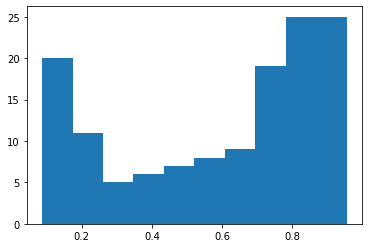

In [8]:
# -6 6

plt.hist(moran)

(array([16., 15., 10.,  4.,  8., 10.,  8., 22., 28., 14.]),
 array([0.04051467, 0.13179387, 0.22307308, 0.31435228, 0.40563149,
        0.4969107 , 0.5881899 , 0.67946911, 0.77074831, 0.86202752,
        0.95330672]),
 <a list of 10 Patch objects>)

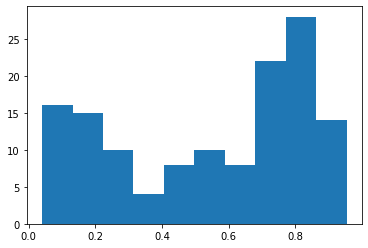

In [11]:
# -8 8
plt.hist(moran)

(array([24., 10., 13.,  8., 12.,  5., 11., 14., 18., 20.]),
 array([0.03105089, 0.12109081, 0.21113072, 0.30117063, 0.39121055,
        0.48125046, 0.57129037, 0.66133029, 0.7513702 , 0.84141011,
        0.93145003]),
 <a list of 10 Patch objects>)

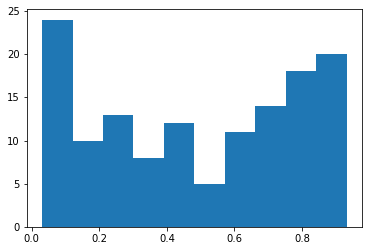

In [14]:
# -10 10
plt.hist(moran)

In [20]:
metadata

,id,relationship,coeficients,trend,surface_level,spatial_autocorrelation,dataset_path,target_path,trend_path
0,0,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,high,dataset-TR_none_rel-linear-lvl_small-sac-high.csv,target-TR_none_rel-linear-lvl_small-sac-high.csv,trend_none.csv
1,1,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,low,dataset-TR_none_rel-linear-lvl_small-sac-low.csv,target-TR_none_rel-linear-lvl_small-sac-low.csv,trend_none.csv
2,2,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,none,dataset-TR_none_rel-linear-lvl_small-sac-none.csv,target-TR_none_rel-linear-lvl_small-sac-none.csv,trend_none.csv
3,3,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,high,dataset-TR_none_rel-polynom2-lvl_small-sac-hig...,target-TR_none_rel-polynom2-lvl_small-sac-high...,trend_none.csv
4,4,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,low,dataset-TR_none_rel-polynom2-lvl_small-sac-low...,target-TR_none_rel-polynom2-lvl_small-sac-low.csv,trend_none.csv
...,...,...,...,...,...,...,...,...,...
130,130,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",random_dis,large,low,dataset-TR_random_dis_rel-polynom2-lvl_large-s...,target-TR_random_dis_rel-polynom2-lvl_large-sa...,trend_random_dis.csv
131,131,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",random_dis,large,none,dataset-TR_random_dis_rel-polynom2-lvl_large-s...,target-TR_random_dis_rel-polynom2-lvl_large-sa...,trend_random_dis.csv
132,132,polynom3,"[[-3, -2, 2, 0.25], [3, -2, 2, -0.25], [-3, 2,...",random_dis,large,high,dataset-TR_random_dis_rel-polynom3-lvl_large-s...,target-TR_random_dis_rel-polynom3-lvl_large-sa...,trend_random_dis.csv
133,133,polynom3,"[[-3, -2, 2, 0.25], [3, -2, 2, -0.25], [-3, 2,...",random_dis,large,low,dataset-TR_random_dis_rel-polynom3-lvl_large-s...,target-TR_random_dis_rel-polynom3-lvl_large-sa...,trend_random_dis.csv


(array([25., 10., 11., 11., 14.,  5.,  9., 11., 18., 21.]),
 array([0.01069344, 0.10414811, 0.19760278, 0.29105745, 0.38451212,
        0.47796679, 0.57142146, 0.66487613, 0.7583308 , 0.85178547,
        0.94524014]),
 <a list of 10 Patch objects>)

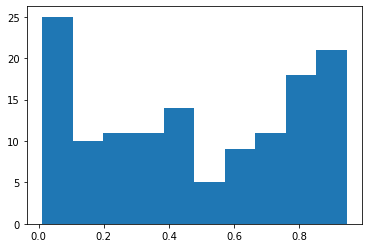

In [22]:
plt.hist(moran)

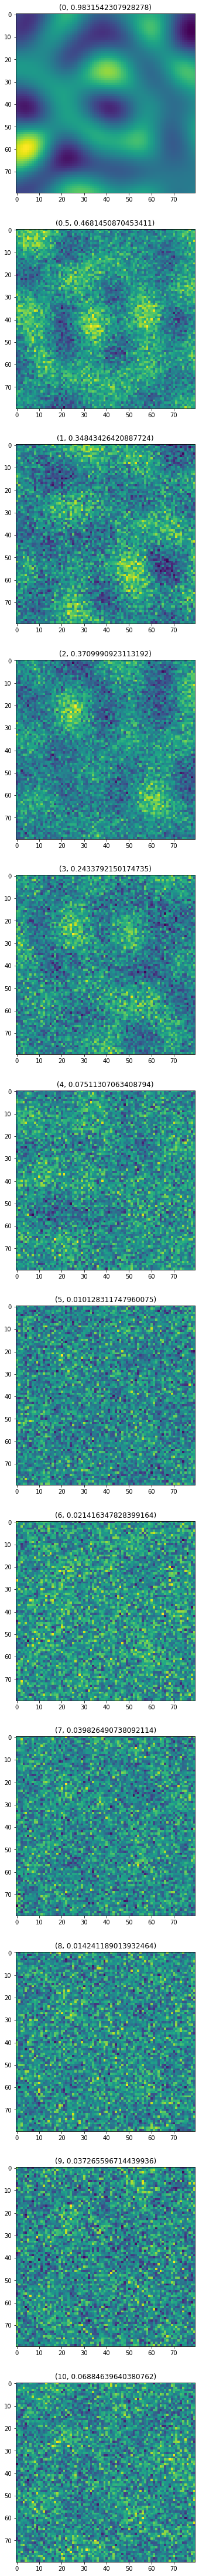

In [80]:
x_size = y_size = 80
model_type = 'gaussian'
param = {'sill': 1, 'range': 20, 'nugget': 10}
spatial_autocorrelation_coef = {'high':0.75, 'low':1, 'none':5}
moranI = []

sac = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
f, ax = plt.subplots(nrows=len(sac), ncols=1, figsize=((8, 80)))

features = np.zeros((6400, 6))
feature_v = np.zeros((6400, 4))


for nk, k in enumerate(sac):
        for n_x in range(4):

                x_f = uniform.rvs(0, x_size, size=s)
                y_f = uniform.rvs(0, y_size, size=s)
                z_f = uniform.rvs(-1, 1, size=s)

                model = OrdinaryKriging(x_f.astype('float'), y_f.astype('float'), z_f, model_type, param)
                values, placeholder = model.execute("grid", gridx, gridy)

                values = values.data.flatten()
                features[:, n_x] = values

                # generate "noise" which will lower spatial autocorrelation
                noise_val = k
                noise = (uniform.rvs(-10, 10, size=x_size*y_size)*noise_val)
                features[:, n_x] = scaler((features[:, n_x] + noise), -1, 1)

                # load coeficient of function/relationship
                trend = np.genfromtxt(f'data_surface\\trend_nonlinear.csv', delimiter=',')
                trend = scaler(trend, 0.9, 1.1)

                feature_v[:, n_x] = function_dict[row[1]['relationship']](features[:, n_x], trend, coef)

        features[:, -2] = x_feature.flatten()
        features[:, -1] = y_feature.flatten()

        V = np.sum(feature_v, axis=1)

        w = lat2W(80, 80, rook=False, id_type="int")
        mi = Moran(V.reshape((80, 80)), w).I
        moranI.append(mi)

        ax[nk].imshow(V.reshape((80,80)))
        ax[nk].set_title((k, mi))

(14,)

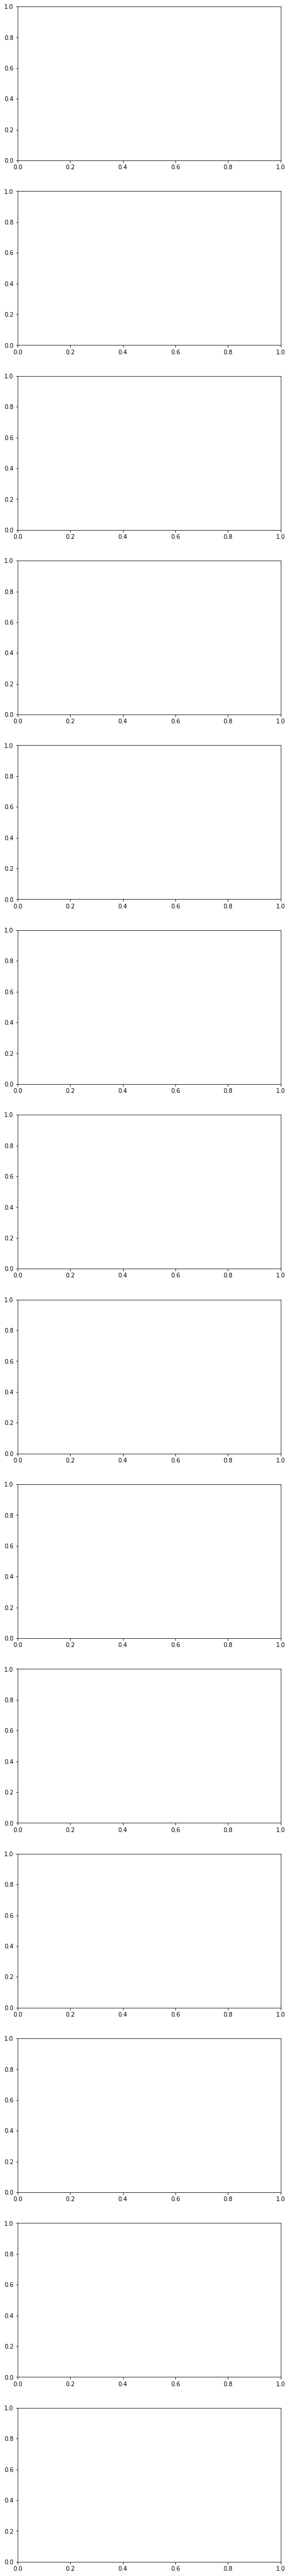

In [71]:
sac = [0, 0.25, 0.5, 0.75, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5, 6, 7]


f, ax = plt.subplots(nrows=len(sac), ncols=1, figsize=((8, 80)))
ax.shape

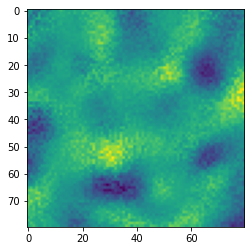

In [45]:
a = metadata.iloc[112]['target_path']
data = np.genfromtxt(f'data_labels\\{a}', delimiter=",")
plt.imshow(data.reshape((80,80)))

In [52]:
for row in tqdm(metadata.iterrows(), total=len(metadata)):

    # generate container for features
    features = np.zeros((6400, 6))
    feature_v = np.zeros((6400, 4))

    # load trend
    trend_name = row[1]['trend']
    trend = np.genfromtxt(f'data_surface\\trend_{trend_name}.csv', delimiter=',')

    # trend values
    trend_level = row[1]['surface_level']

    if trend_name == 'none':
        pass
    else:
        trend = scaler(trend, surface_level_value[trend_level][0], surface_level_value[trend_level][0])

    break

array([1., 1., 1., ..., 1., 1., 1.])

In [33]:
import os 

list_items = os.listdir('data_labels')
moran = []

w = lat2W(80, 80, rook=False, id_type="int")

for x in list_items:

    target = np.genfromtxt(f'data_labels\\{x}')
    mi = Moran(target.reshape((80, 80)), w).I
    moran.append(mi)

d:\PROGRAMY\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1956: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
d:\PROGRAMY\Anaconda\lib\site-packages\esda\moran.py:185: RuntimeWarning: invalid value encountered in greater_equal
  above = sim >= self.I


In [16]:
moran

[0.9776883224475186,
 0.8935949585608385,
 0.7489761619432402,
 0.980049399943232,
 0.9346651396579583,
 0.6942436421691812,
 0.985165773991764,
 0.9221484530871804,
 0.8305570921695007,
 0.9760649060227987,
 0.9146288830421244,
 0.5256685012448947,
 0.9668626734335898,
 0.915284325491315,
 0.5211118724084746,
 0.9624470466052002,
 0.9705520027920443,
 0.5842353715482868,
 0.9627484570271012,
 0.8630383507573427,
 0.4853355529888756,
 0.9720979645947919,
 0.956988552646795,
 0.7854050288935531,
 0.9739382849660688,
 0.9407726926571957,
 0.543022312325614,
 0.9827075234504711,
 0.9478510818630167,
 0.9317619540867454,
 0.9823056866390275,
 0.9697254932358341,
 0.5133969043093081,
 0.9795219356538376,
 0.9563068726215671,
 0.6344938069177194,
 0.9752835632174313,
 0.9292038065570434,
 0.8170070434725888,
 0.9640109268380581,
 0.9376449541340139,
 0.6007322943234041,
 0.9594393240188793,
 0.9450215177702915,
 0.7046468581826392,
 0.9697035195313567,
 0.9700002594686206,
 0.623383916378946

In [35]:
moran

[0.9675796011714103,
 0.8690940373718972,
 0.7675002773341105,
 0.9802318037837648,
 0.9638999242075176,
 0.5624709204436453,
 0.9672588905374293,
 0.9053233587697869,
 0.6897143099781494,
 0.9601342537204529,
 0.9338155177403686,
 0.5853081250702669,
 0.9719491343384287,
 0.9479214363299182,
 0.8608602898632296,
 0.9603708072167723,
 0.896722022552799,
 0.8851731861467191,
 0.9635859955854109,
 0.8709070560928954,
 0.8150358011304368,
 0.9590671213130548,
 0.9524435939254611,
 0.6900503507621351,
 0.9667073794978984,
 0.9301388646513957,
 0.4578564149570761,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.9813808073169703,
 0.9004066559018539,
 0.6187246527341849,
 0.9625193795160923,
 0.8988986883436861,
 0.7768110863388193,
 0.9756845081627777,
 0.7619126689513162,
 0.4656596695979731,
 0.9682825533264553,
 0.8439197368146175,
 0.47671881101454694,
 0.9745501871095527

d:\PROGRAMY\Anaconda\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
d:\PROGRAMY\Anaconda\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 3.,  6.,  4.,  6.,  2.,  7.,  6.,  6., 19., 49.]),
 array([0.38252457, 0.44241019, 0.50229582, 0.56218144, 0.62206706,
        0.68195269, 0.74183831, 0.80172394, 0.86160956, 0.92149518,
        0.98138081]),
 <a list of 10 Patch objects>)

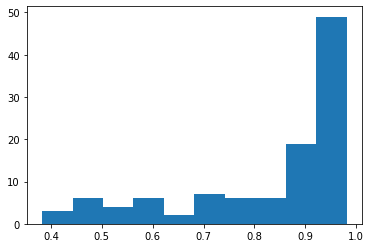

In [34]:
plt.hist(moran)

In [26]:
metadata

,relationship,coeficients,trend,surface_level,spatial_autocorrelation,dataset_path,target_path,trend_path
0,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,high,dataset-TR_none_rel-linear-lvl_small-sac-high.csv,target-TR_none_rel-linear-lvl_small-sac-high.csv,trend_none.csv
1,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,low,dataset-TR_none_rel-linear-lvl_small-sac-low.csv,target-TR_none_rel-linear-lvl_small-sac-low.csv,trend_none.csv
2,linear,"[[1.5, 0.25], [1.5, -0.25], [-1.5, 0.25], [-1....",none,small,none,dataset-TR_none_rel-linear-lvl_small-sac-none.csv,target-TR_none_rel-linear-lvl_small-sac-none.csv,trend_none.csv
3,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,high,dataset-TR_none_rel-polynom2-lvl_small-sac-hig...,target-TR_none_rel-polynom2-lvl_small-sac-high...,trend_none.csv
4,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",none,small,low,dataset-TR_none_rel-polynom2-lvl_small-sac-low...,target-TR_none_rel-polynom2-lvl_small-sac-low.csv,trend_none.csv
...,...,...,...,...,...,...,...,...
130,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",random_dis,large,low,dataset-TR_random_dis_rel-polynom2-lvl_large-s...,target-TR_random_dis_rel-polynom2-lvl_large-sa...,trend_random_dis.csv
131,polynom2,"[[2, -1, 0.25], [-2, -1, -0.25], [-2, 1, -0.25...",random_dis,large,none,dataset-TR_random_dis_rel-polynom2-lvl_large-s...,target-TR_random_dis_rel-polynom2-lvl_large-sa...,trend_random_dis.csv
132,polynom3,"[[-3, -2, 2, 0.25], [3, -2, 2, -0.25], [-3, 2,...",random_dis,large,high,dataset-TR_random_dis_rel-polynom3-lvl_large-s...,target-TR_random_dis_rel-polynom3-lvl_large-sa...,trend_random_dis.csv
133,polynom3,"[[-3, -2, 2, 0.25], [3, -2, 2, -0.25], [-3, 2,...",random_dis,large,low,dataset-TR_random_dis_rel-polynom3-lvl_large-s...,target-TR_random_dis_rel-polynom3-lvl_large-sa...,trend_random_dis.csv


In [30]:
metadata['surface_level'].iloc[36]

'medium'